In [1]:
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from dinov2_feature_extraction import load_model, get_dense_descriptor

from skimage import io



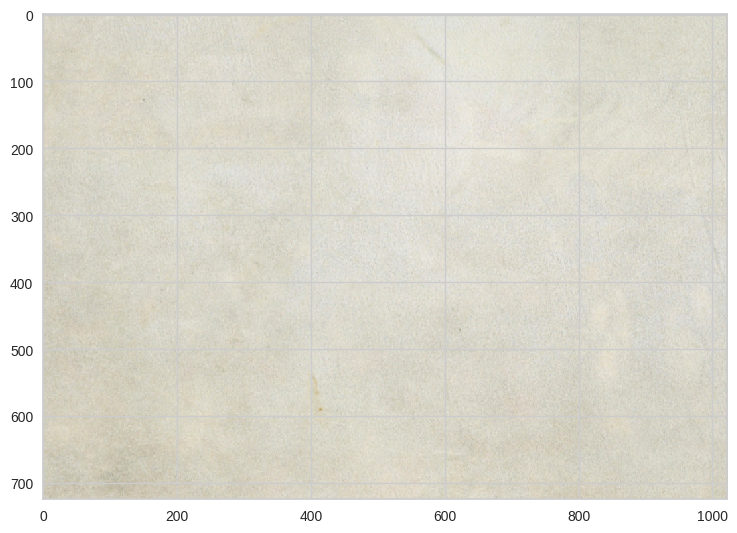

In [2]:
dataset_path_white_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page27.jpg'   
#dataset_path_white_img_2 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page1328.jpg'   
img = io.imread(dataset_path_white_img_1)
io.imshow(img)
io.show()

In [3]:
dinov2_sizes = {"small": 384,
                "base": 768,
                "large": 1024,
                "giant": 1536} # tamaños del feature vector de cada version de dinov2

backbone_size = 'small'
model = load_model(backbone_size)

Using cache found in /home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ignacio/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
from sklearn.decomposition import PCA

features, attention, grid_shape = get_dense_descriptor(model, img)

# Primero, aplicas PCA a tus características originales para reducir la dimensionalidad
pca = PCA(n_components=3)
pca_trained = pca.fit(attention)
pca_features = pca_trained.transform(attention)  

/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

Optimal number of clusters: 6


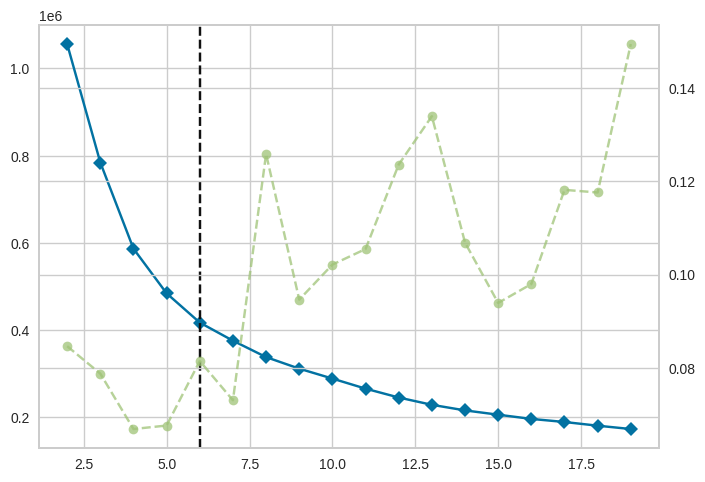

In [5]:
from sklearn.decomposition import PCA

# Initialize the KMeans model
model_kmeans = KMeans()

# Initialize the KElbowVisualizer with the number of clusters and the metric you want to use
visualizer = KElbowVisualizer(model_kmeans, k=(2,20))

# Fit the data to the visualizer
visualizer.fit(pca_features)  

# Get the optimal number of clusters
optimal_clusters = visualizer.elbow_value_

print("Optimal number of clusters:", optimal_clusters)

/home/ignacio/miniconda3/envs/medieval_ret/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


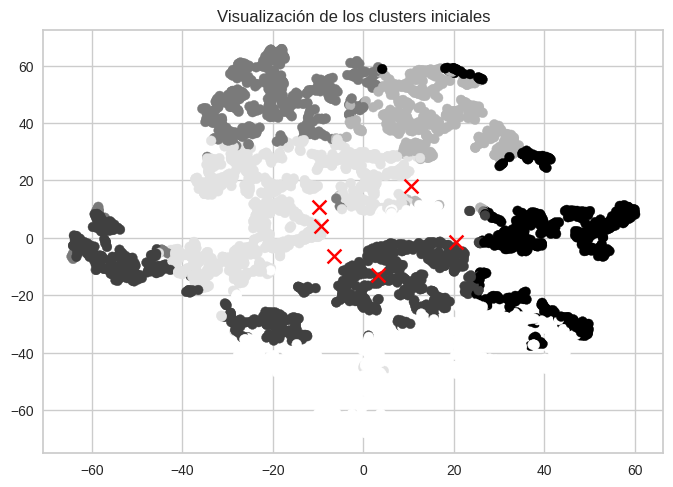

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

number_of_clusters = optimal_clusters

# Luego ajustas K-means a estas características transformadas por PCA
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(pca_features)

# Guardas los centros de los clústeres
cluster_centers = kmeans.cluster_centers_

# Ahora para visualizar los clusters iniciales
reduced_data = TSNE(n_components=2).fit_transform(pca_features)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='x')  # Centros de clusters
plt.title('Visualización de los clusters iniciales')
plt.show()


In [7]:
from decimal import Decimal, getcontext
from dinov2_feature_extraction import min_max_scale
import os
import torch
import numpy as np
from tqdm import tqdm
from skimage import io
from skimage.transform import resize
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu
from sklearn.decomposition import PCA

from skimage import morphology, measure

def pca_colorize_2(features, output_shape, pca):
    # Aplicar PCA como antes
    inverted = False
    remove = True
    rgb = pca.transform(features)
    rgb = min_max_scale(rgb)
    rgb = rgb.reshape(output_shape + (3,))

    # Set the precision you need
    getcontext().prec = 10

    mean_color = np.mean(rgb, axis=(0, 1))
    print(mean_color)
    dominant_color = np.argmax(mean_color)
    print(dominant_color)
    # Convert numpy.float32 to native Python float, then to Decimal
    mean_color_0 = Decimal(float(mean_color[0]))
    mean_color_2 = Decimal(float(mean_color[2]))

    # Calculate the difference using Decimal
    diff =  mean_color_2-mean_color_0

    # Calculate the difference using Decimal
    diff_2 =  mean_color_0 - mean_color_2

    # Aplicar umbral de Otsu al color dominante
    thresh = threshold_otsu(rgb[:, :, 0])
    rgb_mask = (rgb[:, :, 0] > thresh)*1

    # Invertir la máscara si el color dominante no es el primero
    if dominant_color == 0:
        print("invertir")
        inverted = True
        rgb_mask = 1 - rgb_mask

    if dominant_color == 2 :
        remove = False

    if dominant_color == 0 :
        remove = False
    rgb[:, :, 0] *= rgb_mask
    rgb[:, :, 1] *= rgb_mask
    rgb[:, :, 2] *= rgb_mask
    rgb = min_max_scale(rgb)
    print("remove", remove)
    return rgb, inverted, remove



def foreground_mask_2(attention_rgb, remove, use_bbox=True):
    # Crear la máscara básica
    attention_mask = attention_rgb.mean(axis=-1) > 0
    attention_mask = morphology.binary_dilation(attention_mask)
    if not remove:
        print("no remove")
        # Crear una matriz de unos con las mismas dimensiones que attention_mask
        return np.ones_like(attention_mask)

    if use_bbox:
        attention_labeled = measure.label(attention_mask)
        regions = measure.regionprops(attention_labeled)
        '''
        if inverted:
            # Crear una máscara invertida donde se mantenga todo excepto las bounding boxes
            inverted_mask = np.ones_like(attention_mask, dtype=bool)
            for props in regions:
                ymin, xmin, ymax, xmax = props.bbox
                inverted_mask[ymin:ymax, xmin:xmax] = False
            return inverted_mask
         else:
        '''
        
        # Proceso normal: expandir la máscara dentro de los bounding boxes
        for props in regions:
            ymin, xmin, ymax, xmax = props.bbox
            attention_mask[ymin:ymax, xmin:xmax] = True

    return attention_mask

In [8]:
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page1.jpg'  
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page4.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page40.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page114.jpg'   
#dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page104.jpg'   
dataset_path_new_img_1 = r'/home/ignacio/2024-1/tesis/verano/medieval_image_retrieval/DocExplore_images/page32.jpg'  


[0.43939552 0.41809478 0.34740505]
0
invertir
remove False


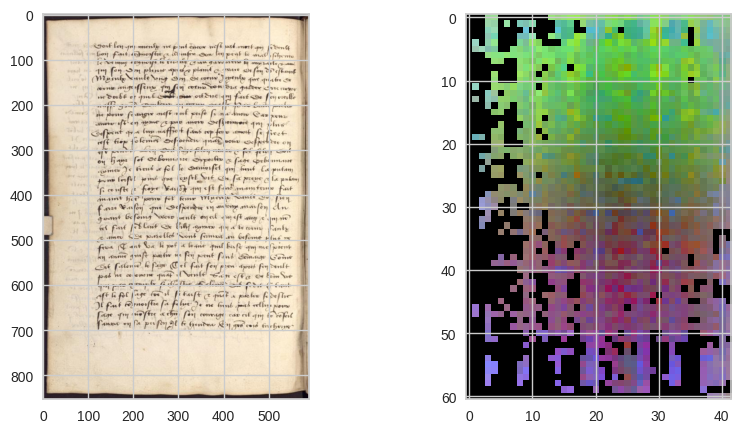

'\ntest_mask_box_2 = foreground_mask_2(test, inverted, remove, use_bbox=True)\nio.imshow(test_mask_box_2)\nio.show()\n'

In [9]:
new_img = io.imread(dataset_path_new_img_1)


new_image_features, new_image_attention, new_image_grid_shape = get_dense_descriptor(model, new_img)

#io.imshow(new_img)
#io.show()

test, inverted, remove = pca_colorize_2(new_image_attention, new_image_grid_shape, pca)
#io.imshow(test)
#io.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) 
axes[0].imshow(new_img) 
axes[1].imshow(test) 

plt.show() 

'''
test_mask = foreground_mask(test, use_bbox=False)
io.imshow(test_mask)
io.show()

test_mask_box = foreground_mask(test, use_bbox=True)
io.imshow(test_mask_box)
io.show()
'''
'''
test_mask_box_2 = foreground_mask_2(test, inverted, remove, use_bbox=True)
io.imshow(test_mask_box_2)
io.show()
'''



In [10]:
import numpy as np
from sklearn.decomposition import PCA
from PIL import Image

def pca_component_images(features, output_shape):
    # Aplicar PCA para obtener 3 componentes principales
    pca = PCA(n_components=3)
    pca_components = pca.fit_transform(features)

    # Función para escalar y convertir un componente en una imagen
    def component_to_image(component):
        component_scaled = (component - np.min(component)) / (np.max(component) - np.min(component))
        component_scaled = (component_scaled * 255).astype(np.uint8)
        return Image.fromarray(component_scaled.reshape(output_shape))

    # Convertir cada componente en una imagen
    image1 = component_to_image(pca_components[:, 0])
    image2 = component_to_image(pca_components[:, 1])
    image3 = component_to_image(pca_components[:, 2])

    return image1, image2, image3


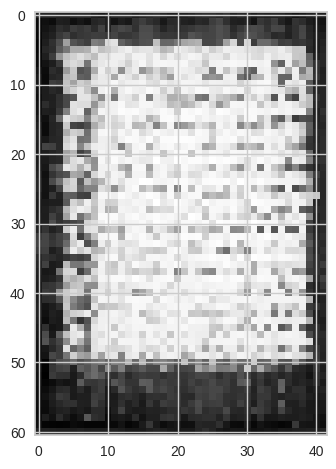

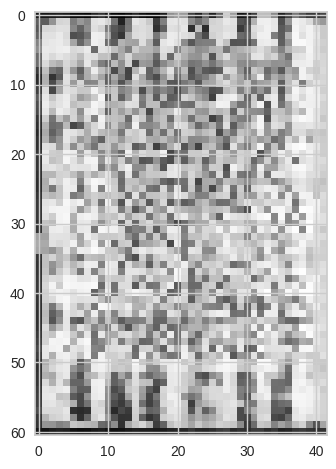

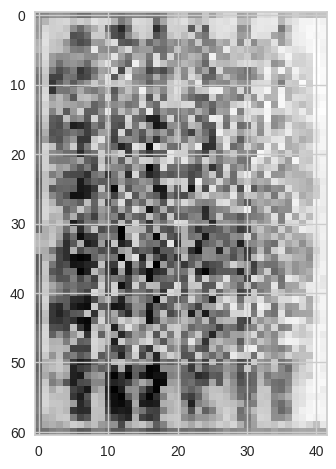

In [11]:
test1, test2, test3 = pca_component_images(new_image_attention, new_image_grid_shape)
test1_array = np.array(test1)
test2_array = np.array(test2)
test3_array = np.array(test3)

# Ahora puedes utilizar plt.imshow para mostrar las imágenes
plt.imshow(test1_array)
plt.show()
plt.imshow(test2_array)
plt.show()
plt.imshow(test3_array)
plt.show()